## Import required modules

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## Import data + checking missing values

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
missing = df.isnull().sum()/df.isnull().count()*100
missing_data_columns = missing.index[missing!=0]
missing.sort_values(ascending = False)

Cabin          77.104377
Age            19.865320
Embarked        0.224467
Fare            0.000000
Ticket          0.000000
Parch           0.000000
SibSp           0.000000
Sex             0.000000
Name            0.000000
Pclass          0.000000
Survived        0.000000
PassengerId     0.000000
dtype: float64

## Explore & filling columns with missing data

In [3]:
df_missing = df[missing_data_columns]
print(df_missing.head())

    Age Cabin Embarked
0  22.0   NaN        S
1  38.0   C85        C
2  26.0   NaN        S
3  35.0  C123        S
4  35.0   NaN        S


#### <font color = #FFF8C6> Cabin has too many missing data and it is a string with countless possibilities, impossible for us to fill data in meaningful way, drop from dataset </font>

In [4]:
df_missing['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

### Filling ages column according to mean of each salutation

In [5]:
# Groups passengers by salutations
df['Salutation'] = df['Name'].apply(lambda name: name.split(',')[1].split('.')[0])
# fill missing ages with mean of salutations note: x in lambda refers to the group!
df['Age'] = df.groupby('Salutation')['Age'].apply(lambda x: x.fillna(x.mean()))

### Binning ages, to see if it helps prediction

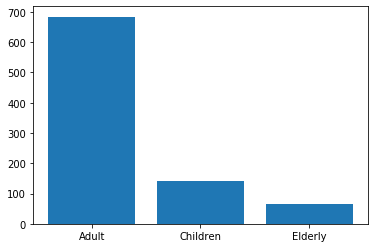

In [6]:
age_labels = ['Children','Adult','Elderly']
df['Age_group']=pd.cut(df['Age'], [0,18,50,df['Age'].max()], labels = age_labels)
plt.bar(df['Age_group'].value_counts().index,df['Age_group'].value_counts())
plt.show()

### Fill embarked with mode of column

In [10]:
df['Embarked'].fillna(str(df.Embarked.mode()), inplace = True)
#df.Embarked.mode() is a Series, need to be converted to string, quite silly, really.

In [11]:
df.isnull().sum()
#All filled up!

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Salutation       0
Age_group        0
dtype: int64

## Feature selection

### Dropping useless features and converting Pclass to categorical

In [ ]:
df_useful = df.drop(columns = ['PassengerId','Name','Cabin','Ticket','Salutation','Parch','SibSp','Age'])
df_useful['Pclass'] = df_useful['Pclass'].astype(str)

In [ ]:
df_binaried = pd.get_dummies(df_useful)

In [ ]:
df_binaried.dtypes

### Plotting heatmap of correlation, just for visualisation

In [ ]:
corr = df_binaried.corr()
sns.heatmap(abs(corr))
plt.show()

In [ ]:
abs(corr['Survived']).sort_values(ascending = False)

## Making and tuning models

### Making an SVC model

In [ ]:
X = df_binaried.loc[:,df_binaried.columns != 'Survived']
y = df_binaried['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y)

for g in np.logspace(-4,1,6):
    clf = SVC(kernel = 'rbf', gamma = g).fit(X_train, y_train)
    print('Gamma value:',g)
    print('Test score: {:.2f}'.format(clf.score(X_test,y_test)))
    print('Train score: {:.2f}'.format(clf.score(X_train,y_train)))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for g in np.logspace(-4,1,6):
    clf = SVC(kernel = 'rbf', gamma = g).fit(X_train_scaled, y_train)
    print('Gamma value:',g)
    print('Test score: {:.2f}'.format(clf.score(X_test_scaled,y_test)))
    print('Train score: {:.2f}'.format(clf.score(X_train_scaled,y_train)))

### Validation curve without feature normalisation

In [ ]:
from sklearn.model_selection import validation_curve
train_scores, valid_scores = validation_curve(SVC(kernel = 'rbf'), X, y, "gamma", 
                                                  np.logspace(-4,1,6), cv = 3)
cv_scores = np.mean(train_scores, axis = 1),np.mean(valid_scores, axis = 1)
pd.DataFrame(cv_scores, index = ['Train scores','Test scores'], columns =np.logspace(-4,1,6) )

### Validation curve after scaling

In [ ]:
X_scaled = scaler.fit_transform(X)
scaled_train_scores, scaled_valid_scores = validation_curve(SVC(kernel = 'rbf'), X_scaled, y, "gamma", 
                                                  np.logspace(-4,2,7), cv = 3)
scaled_cv_scores = np.mean(scaled_train_scores, axis = 1),np.mean(scaled_valid_scores, axis = 1)
pd.DataFrame(scaled_cv_scores, index = ['Train scores','Test scores'], columns =np.logspace(-4,2,7) )

### Logistic regression model with scaling

In [ ]:
from sklearn.linear_model import LogisticRegression
for this_c in [0.0001,0.001,.01,.1,1,10,100]:
    lg_clf = LogisticRegression(C = this_c, solver = 'liblinear').fit(X_train_scaled, y_train)
    print('C = {}, train score: {:.2f}'.format(this_c,lg_clf.score(X_train_scaled,y_train)))
    print('C = {}, test score: {:.2f}'.format(this_c,lg_clf.score(X_test_scaled,y_test)))
# increase in C, increases in fitting of model to train data (more overfitting)


## Generating model with full training set
Just for simplicity, I have chosen a logistic regression model with C = 0.01, I will return to the model selection step when I know of better ways to select models

In [ ]:
X_scaled = scaler.fit_transform(X)
chosen_model = LogisticRegression(C = 0.01, solver = 'liblinear').fit(X_scaled,y)

## Preprocessing test data 

In [ ]:
df_test.isnull().sum()

### Test data will need filling: Age column and fare, I shall do both with mean, out of laziness.

In [ ]:
df_test['Fare'].fillna(df_test.Fare.mean(), inplace = True)
df_test['Age'].fillna(df_test.Age.mean(), inplace = True)
df_test.isnull().sum()

In [ ]:
df_test_selected = df_test.drop(columns = ['PassengerId','Name','Cabin','Ticket','Parch','SibSp'])
df_test_selected['Pclass'] = df_useful['Pclass'].astype(str)
df_test_processed = pd.get_dummies(df_test_selected)
df_test_scaled = scaler.fit_transform(df_test_processed)

### DONE!

## Making prediction on test data and generating CSV

In [ ]:
answer = pd.Series(chosen_model.predict(df_test_scaled), name = 'Survived')
df_answer = pd.concat([df_test['PassengerId'],answer], axis = 1)

In [ ]:
df_answer.to_csv(r'/Users/jansen/documents/dspractice/kaggle/titanic_answer.csv',index = None)

In [ ]:
model2 = SVC(kernel = 'rbf', gamma = 10).fit(X_scaled, y)
answer2 = pd.Series(model2.predict(df_test_scaled), name = 'Survived')

In [ ]:
answerSVC = pd.concat([df_test['PassengerId'],answer2], axis = 1)
answerSVC.to_csv(r'/Users/jansen/documents/dspractice/kaggle/titanic_answer_SVC.csv',index = None)